# Supervised linear regression machine learning model to predict the primary dendritic arm spacing

# Project Overview

we develop a supervised-regression machine learning model to obtain a correlation between the PDAS and velocity and temperature gradient


# Data Wrangling

### 1. Sourcing and loading

#### 1a. Import relevant libraries 

In [1]:
# Import relevant libraries and packages.
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt 
import seaborn as sns # For all our visualization needs.
import statsmodels.api as sm # Second library for linear regression model based on OLS
from statsmodels.graphics.api import abline_plot # What does this do? Find out and type here.
from sklearn.metrics import mean_squared_error, r2_score # acess performance.
from sklearn.model_selection import train_test_split,cross_validate,KFold,cross_val_score #split data in training and testing dataset
from sklearn import linear_model, preprocessing # linear regression models
import warnings # For handling error messages.
# Don't worry about the following two instructions: they just suppress warnings that could occur later. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

#### 1b. Load the data

We have generated the data, so we know they are almost clean. However, I perfowm the typical data wrangling steps use dto idensify if there are any problems with the data files

In [2]:
# Load the data. 
df=pd.read_csv("PDAS_all.csv")

#### 1c. Exploring the data

In [3]:
# Check out its appearance. 
df.head(n=5)

,V,G,Mat_HB,Mat_KF,PDAS
0,0.01,10000000.0,2.020000e-14,2.570000e-13,2.468570e-06
1,0.02,10000000.0,2.020000e-14,2.570000e-13,2.160000e-06
2,0.03,10000000.0,2.020000e-14,2.570000e-13,1.080000e-06
3,0.04,10000000.0,2.020000e-14,2.570000e-13,9.257140e-07
4,0.05,10000000.0,2.020000e-14,2.570000e-13,8.100000e-07


In [4]:
# overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V       250 non-null    float64
 1   G       250 non-null    float64
 2   Mat_HB  250 non-null    float64
 3   Mat_KF  250 non-null    float64
 4   PDAS    250 non-null    float64
dtypes: float64(5)
memory usage: 9.9 KB


Because I have already generated the data I know the data are all in correct format and all the rows have correct values.
However this shows all columns have correct data type. They also do not have a missing value

In [5]:
df.isna().any()

V         False
G         False
Mat_HB    False
Mat_KF    False
PDAS      False
dtype: bool

As expected, we do not have any NULL values

In [6]:
df.duplicated().any()

False

In [7]:
df['Mat_HB'].nunique()

7

The data set have overall data for 7 alloys. for each alloy the PDAS is calculated based on different values of V and G.

In [8]:
print(df["Mat_HB"].unique())

[2.02e-14 3.37e-14 3.51e-14 5.85e-15 2.30e-15 4.33e-15 5.11e-15]


In [9]:
# We need a new column showing the alloy name
# we know Mat_HB of 2.02e-14 3.37e-14 3.51e-14 5.85e-15 2.30e-15 4.33e-15 5.11e-15 belonds to Ti-3.4%Ni, Ti-7.1%Ni, Ti-10.6%Ni, 
# Mg-9 at% Al, Al-6 at%Cu, Al-8 at%Cu, and Al-10 at%Cu

conditions=[np.logical_and(df["Mat_HB"].gt(2.01e-14),df["Mat_HB"].lt(2.03e-14)),
            np.logical_and(df["Mat_HB"].gt(3.36e-14),df["Mat_HB"].lt(3.38e-14)),
            np.logical_and(df["Mat_HB"].gt(3.50e-14),df["Mat_HB"].lt(3.52e-14)),
            np.logical_and(df["Mat_HB"].gt(5.84e-15),df["Mat_HB"].lt(5.86e-15)),
            np.logical_and(df["Mat_HB"].gt(2.29e-15),df["Mat_HB"].lt(2.31e-15)),
            np.logical_and(df["Mat_HB"].gt(4.32e-15),df["Mat_HB"].lt(4.34e-15)),
            np.logical_and(df["Mat_HB"].gt(5.10e-15),df["Mat_HB"].lt(5.12e-15))]
outputs=["Ti-3.4 at% Ni","Ti-7.1 at% Ni","Ti-10.7 at% Ni","Mg- 9 at% Al","Al-6 at% Cu","Al-8 at% Cu","Al-10 at% Cu"]
df["Alloy"]=pd.Series(np.select(conditions,outputs,"alloy"))


In [10]:
# OUR equation will have the following format PDAS=A (V)^alpha (G)^beta (matprop)^gamma. To make this easier to change to
# a regression model, 
# we will first deside the dependent variable as PDAS and then We will take ln of all the columns and add it to a new column
#and move forward with that
df.head()

,V,G,Mat_HB,Mat_KF,PDAS,Alloy
0,0.01,10000000.0,2.020000e-14,2.570000e-13,2.468570e-06,Ti-3.4 at% Ni
1,0.02,10000000.0,2.020000e-14,2.570000e-13,2.160000e-06,Ti-3.4 at% Ni
2,0.03,10000000.0,2.020000e-14,2.570000e-13,1.080000e-06,Ti-3.4 at% Ni
3,0.04,10000000.0,2.020000e-14,2.570000e-13,9.257140e-07,Ti-3.4 at% Ni
4,0.05,10000000.0,2.020000e-14,2.570000e-13,8.100000e-07,Ti-3.4 at% Ni


In [11]:
# Get a basic statistical summary of the dependent variable 
#PDAS is our fixed dependent variable
df["PDAS"].describe()

count    2.500000e+02
mean     2.573232e-06
std      6.532639e-06
min      1.322670e-07
25%      4.926000e-07
50%      8.134800e-07
75%      1.470000e-06
max      6.294750e-05
Name: PDAS, dtype: float64

In [12]:
df["PDAS_ln"]=np.log(df["PDAS"])
df["V_ln"]=np.log(df["V"])
df["G_ln"]=np.log(df["G"])
df["Mat_HB_ln"]=np.log(df["Mat_HB"])
df["Mat_KF_ln"]=np.log(df["Mat_KF"])
df_ln=df.drop(["PDAS","V","G","Mat_HB","Mat_KF"],axis=1)

In [13]:
# Call the .corr() method on the wine dataset 
df_ln.corr(method='pearson')

,PDAS_ln,V_ln,G_ln,Mat_HB_ln,Mat_KF_ln
PDAS_ln,1.000000,-0.817739,-0.180500,0.502430,0.411290
V_ln,-0.817739,1.000000,-0.042756,-0.133750,-0.087158
G_ln,-0.180500,-0.042756,1.000000,0.098657,0.242190
Mat_HB_ln,0.502430,-0.133750,0.098657,1.000000,0.962904
Mat_KF_ln,0.411290,-0.087158,0.242190,0.962904,1.000000


# Exploratory Data Analysis

Now that we've chosen PDAS as our dependent variable for regression analysis, we can begin by plotting the pairwise relationships in the dataset, to check out how our variables relate to one another.
if we plot the pairwise relationshi for V,G,matprop_HB,matprop_KF we do not see any specific relationship, but plotting the logaritmic in base e it will have useful information

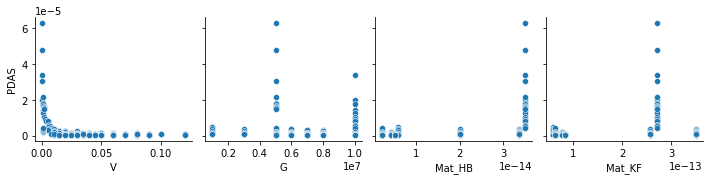

In [14]:
# Make a pairplot of the data just for PDAS
sns.pairplot(df,y_vars=["PDAS"],x_vars=["V","G","Mat_HB","Mat_KF"])

Visualization in this section helped us make sure we do not have any outliers in the PDAS data. However as said previously we need to checl the logaraithmic form of PDAS.
The results do not present a specific trend in for G , mat_HB, mat_Kf in comparison with the 

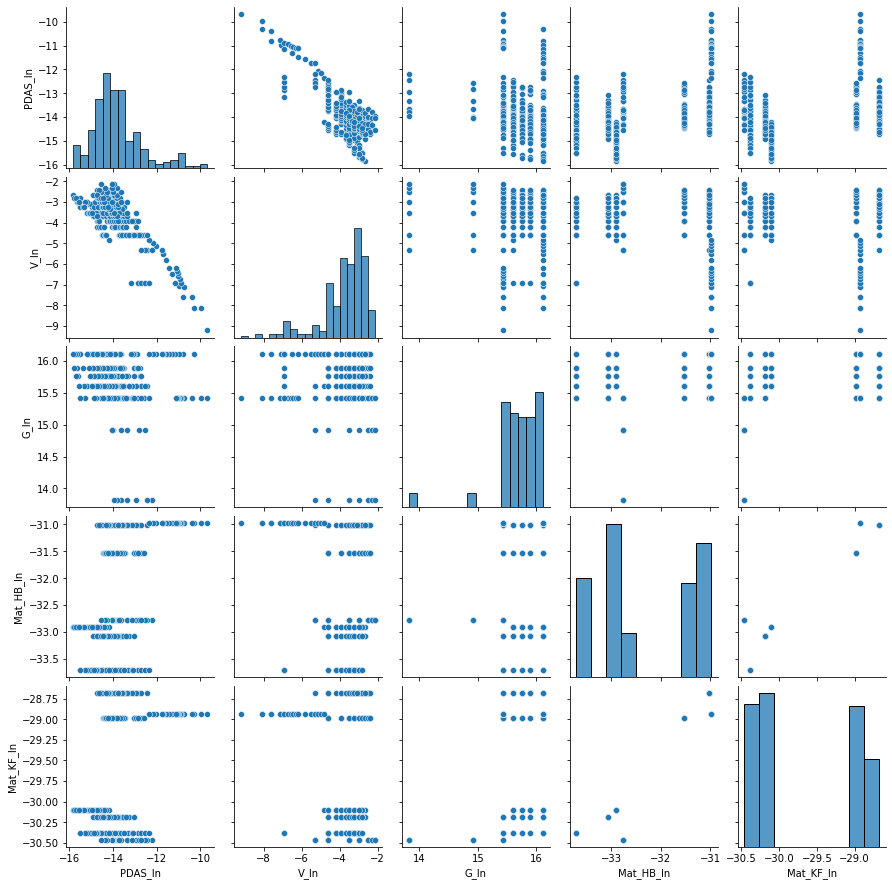

In [15]:
# Make a pairplot of the data
#sns.pairplot(df)
sns.pairplot(df_ln)

So we now have called the .corr() method, and the .pairplot() Seaborn method, on our data. Both have flaws. Happily, we can get the best of both worlds with a heatmap. 

<AxesSubplot:>

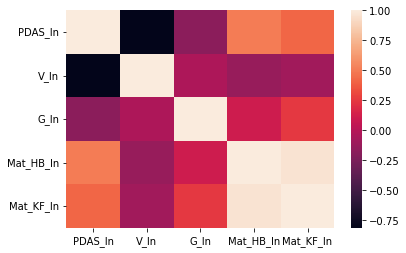

In [16]:
# Make a heatmap of the data 
sns.heatmap(df_ln.corr())

We find a strong correlation (negative) between PDAS_ln and V_ln, also PDAS_ln and G_ln. both HB and KF material properties also have strong but positive effects on PDAS_ln

In [17]:
color=sns.color_palette("husl", 7).as_hex()
print(color[0])

#f77189


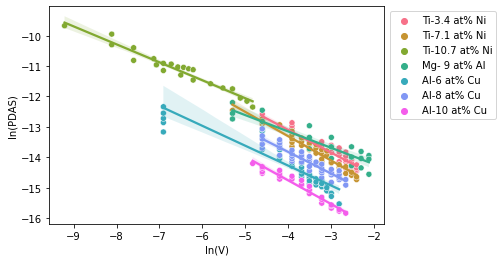

In [18]:
sns.scatterplot(data=df_ln,x="V_ln",y="PDAS_ln",hue="Alloy",palette=sns.color_palette("husl", 7)) #sizes=(20, 100),size="Mat_KF_ln",
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[0]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[0]}) #,line_kws={"color":"red"}
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[1]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[1]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[2]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[2]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[3]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[3]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[4]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[4]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[5]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[5]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[6]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[6]})
plt.xlabel("ln(V)")
plt.ylabel("ln(PDAS)")
plt.legend(bbox_to_anchor=(1.35 , 1), loc="upper right")

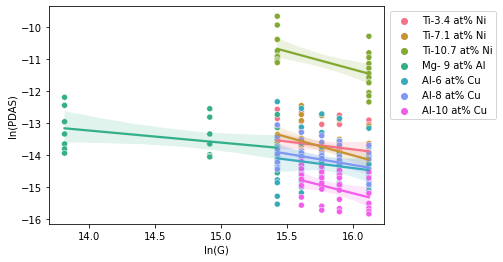

In [19]:
sns.scatterplot(data=df_ln,x="G_ln",y="PDAS_ln",hue="Alloy",palette=sns.color_palette("husl", 7)) #sizes=(20, 100),size="Mat_KF_ln",
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[0]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[0]}) #,line_kws={"color":"red"}
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[1]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[1]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[2]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[2]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[3]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[3]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[4]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[4]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[5]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[5]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[6]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[6]})
plt.xlabel("ln(G)")
plt.ylabel("ln(PDAS)")
plt.legend(bbox_to_anchor=(1.35 , 1), loc="upper right")

This shows we obtain a decending behavior between PDAS with both V and G , while it seems V have a stronger effect. This was also supported by the heatmap plot.